# OpenMapFlow Tutorial

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/3maps.gif" width="80%"/>

### Sections
1. Installing OpenMapFlow
2. Exploring labeled earth observation data
3. Training a cropland model
4. Doing inference over small region
5. [OPTIONAL] Deploying of best model

### Prerequisites:
- Github account
- Github access token (obtained [here](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token))
- Forked OpenMapFlow repository 
- Basic Python knowledge  

### Editable Google Doc for Q&A:
https://docs.google.com/document/d/1Kp6MphER1G5tdLYeAzl4n19S10TweIxiYT64rXsjKm4/edit?usp=sharing

## 1. Clone Github repo and install OpenMapFlow

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/title.png" width="70%"/>

In [1]:
from ipywidgets import HTML, Password, Text, Textarea, VBox
inputs = [
      Password(description="Github Token:"),
      Text(description='Github Email:'),
      Text(description='Github User:'),
]
VBox(inputs)

The OpenMapFlow repository will be cloned to allow access to already available data. 

Ensure you have created a fork of the repository. 

In [2]:
token = inputs[0].value
email = inputs[1].value
username = inputs[2].value

github_url_input = Textarea(value=f'https://github.com/{username}/openmapflow.git')
VBox([HTML(value="<b>Github Clone URL</b>"), github_url_input])

In [3]:
from pathlib import Path

github_url = github_url_input.value
project_name = "crop-mask-example"

for input_value in [token, email, username, github_url]:
  if input_value.strip() == "":
    raise ValueError("Found input with blank value.") 

path_to_project = f"{Path(github_url).stem}/{project_name}"

#!git config --global user.email $username
#!git config --global user.name $email
#!git clone {github_url.replace("https://", f"https://{username}:{token}@")}

!pip install openmapflow -q
!pip install wandb pyyaml==5.4.1 -q

#%cd {path_to_project}

You should consider upgrading via the '/Users/izvonkov/nasaharvest/openmapflow/venv/bin/python -m pip install --upgrade pip' command.
ERROR: python-benedict 0.25.1 has requirement pyyaml<7.0,>=6.0, but you'll have pyyaml 5.4.1 which is incompatible.
ERROR: openmapflow 0.0.1rc1 has requirement pyyaml>=6.0, but you'll have pyyaml 5.4.1 which is incompatible.
You should consider upgrading via the '/Users/izvonkov/nasaharvest/openmapflow/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
# CLI
!openmapflow

---------------------------------------------------------------------------------
                              OpenMapFlow CLI
---------------------------------------------------------------------------------
openmapflow cp <source> <destination> - copy a file or directory from the library
openmapflow create-features - creates features for all datasets in datasets.py
openmapflow datapath <DATAPATH> - outputs a relative path to the data directory
openmapflow datasets - outputs a list of all datasets
openmapflow deploy - deploys Google Cloud Architecture for project
openmapflow dir - outputs openmapflow library directory
openmapflow generate - generates an openmapflow project
openmapflow help - outputs this message
openmapflow ls - lists files in openmapflow library directory
openmapflow version - package version


## 2. Exploring labeled earth observation data 🛰️

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/step1.png" width="70%"/>

In [1]:
# Pull in data already available
!dvc pull -q
!tar -xzf $(openmapflow datapath COMPRESSED_FEATURES) -C data

In [6]:
# See report of data already available
!openmapflow datasets

DATASET REPORT (autogenerated, do not edit directly)

geowiki_landcover_2017 (Timesteps: 24)
----------------------------------------------------------------------------
✔ training amount: 34270,positive class: 21.2%


Togo_2019 (Timesteps: 24)
----------------------------------------------------------------------------
✔ training amount: 991,positive class: 53.0%
✔ testing amount: 309,positive class: 34.6%
✔ validation amount: 277,positive class: 56.7%


All data:
✔ Found no empty features
✔ No duplicates found

### Exploring labels

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datasets import datasets
from openmapflow.constants import LAT, LON, DATASET, SUBSET

In [4]:
# Load labels as csv
df = pd.concat([d.load_labels() for d in datasets])
df.head()

,lon,lat,start_date,end_date,source,class_probability,num_labelers,subset,analysis_duration,email,country,dataset,filename,feature_dir,save_path,already_exists
0,46.25,-16.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.000000,5,training,",,,,",",,,,",global,geowiki_landcover_2017,lat=-16.54761905_lon=46.25_date=2017-01-01_201...,data/features,data/features/lat=-16.54761905_lon=46.25_date=...,True
1,48.25,-18.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.136000,5,training,",,,,",",,,,",global,geowiki_landcover_2017,lat=-18.54761905_lon=48.25_date=2017-01-01_201...,data/features,data/features/lat=-18.54761905_lon=48.25_date=...,True
2,44.25,-21.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.000000,5,training,",,,,",",,,,",global,geowiki_landcover_2017,lat=-21.54761905_lon=44.25_date=2017-01-01_201...,data/features,data/features/lat=-21.54761905_lon=44.25_date=...,True
3,45.25,-17.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.073333,12,training,",,,,,,,,,,,",",,,,,,,,,,,",global,geowiki_landcover_2017,lat=-17.54761905_lon=45.25_date=2017-01-01_201...,data/features,data/features/lat=-17.54761905_lon=45.25_date=...,True
4,46.25,-21.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.000000,5,training,",,,,",",,,,",global,geowiki_landcover_2017,lat=-21.54761905_lon=46.25_date=2017-01-01_201...,data/features,data/features/lat=-21.54761905_lon=46.25_date=...,True


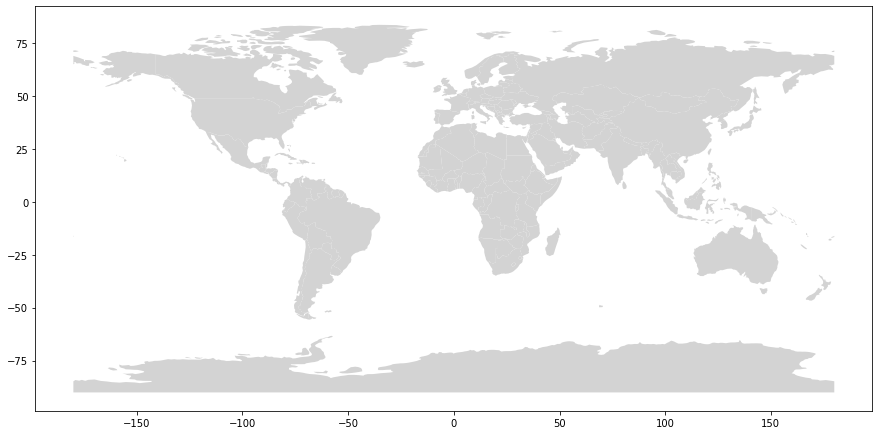

In [5]:
# Plot map where labels should go
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(facecolor="lightgray", figsize=(15, 15));

In [6]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [7]:
# Convert pandas dataframe to geopandas dataframe
gdf = gpd.GeoDataFrame(df)
gdf["geometry"] = [Point(xy) for xy in zip(gdf[LON], gdf[LAT])]

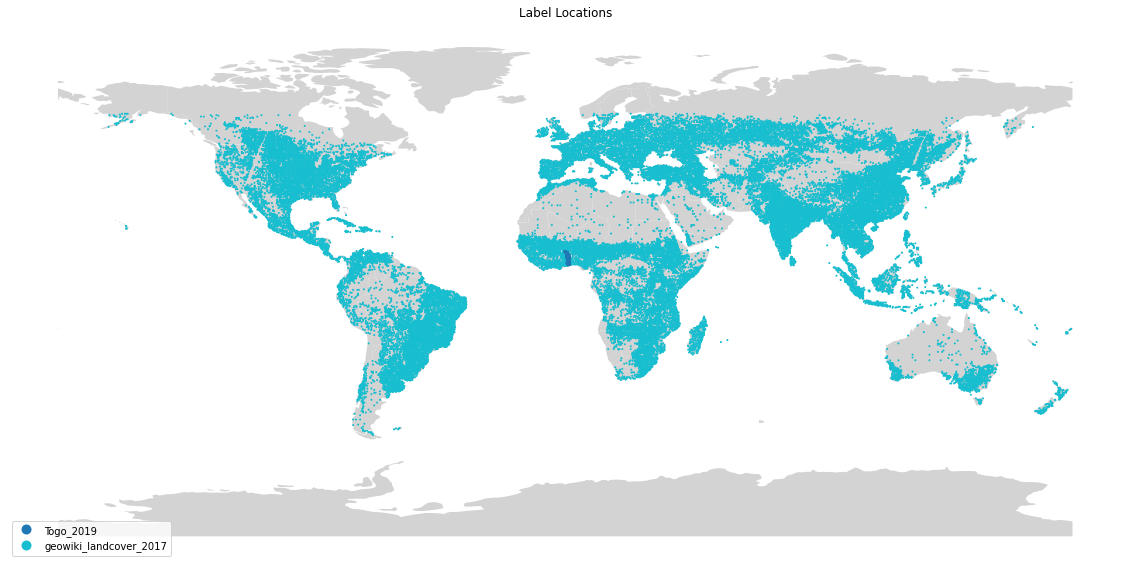

In [8]:
ax = world.plot(figsize=(20,20), facecolor="lightgray")
ax.set_title("Label Locations")
ax.axis('off')
gdf.plot(
    ax=ax, 
    marker='o', 
    categorical=True,
    markersize=1,
    column=DATASET,
    legend=True,
    legend_kwds={'loc': 'lower left'});

In [9]:
gdf.columns

Index(['lon', 'lat', 'start_date', 'end_date', 'source', 'class_probability',
       'num_labelers', 'subset', 'analysis_duration', 'email', 'country',
       'dataset', 'filename', 'feature_dir', 'save_path', 'already_exists',
       'geometry'],
      dtype='object')

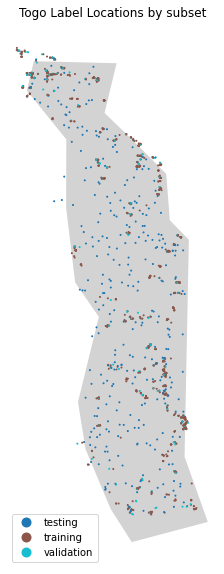

In [10]:
def get_bounds(gdf):
  minx = gdf.bounds.minx.min()
  miny = gdf.bounds.miny.min()
  maxx = gdf.bounds.maxx.max()
  maxy = gdf.bounds.maxy.max() 
  return minx, miny, maxx, maxy
togo_country = world[world["name"] == "Togo"]
ax = togo_country.plot(figsize=(10,10), facecolor="lightgray")

minx, miny, maxx, maxy = get_bounds(togo_country)
assert -1 < minx < 0, f"Country minx: {minx} is incorrect"
assert 5 < miny < 6, f"Country miny: {miny} is incorrect"
assert 0 < maxx < 2, f"Country maxx: {maxx} is incorrect"
assert 11 < maxy < 12, f"Country maxy: {maxy} is incorrect"

togo_points = gdf[gdf["country"] == "Togo"]
minx, miny, maxx, maxy = get_bounds(togo_points)
assert -1 < minx, f"Points minx: {minx} is incorrect"
assert 5 < miny, f"Points miny: {miny} is incorrect"
assert maxx < 2, f"Points maxx: {maxx} is incorrect"
assert maxy < 12, f"Points maxy: {maxy} is incorrect"

ax.set_title("Togo Label Locations by subset")
ax.axis('off')

togo_points.plot(
    ax=ax, 
    marker='o', 
    categorical=True,
    markersize=1,
    column="subset",
    legend=True,
    legend_kwds={'loc': 'lower left'});

### Exploring earth observation data

In [11]:
import matplotlib.pyplot as plt
from openmapflow.constants import FEATURE_PATH, CLASS_PROB, MONTHS
from openmapflow.features import load_feature
from cropharvest.engineer import BANDS

In [12]:
# Get a label with postive class
crop_label = df[(df[CLASS_PROB] == 1.0) & (df[SUBSET] == "validation")].iloc[0]
crop_label

lon                                                           1.412409
lat                                                           7.584598
start_date                                                  2019-01-01
end_date                                                    2020-12-31
source                                              crop_merged_v2.zip
class_probability                                                  1.0
num_labelers                                                         1
subset                                                      validation
analysis_duration                                                  NaN
email                                                              NaN
country                                                           Togo
dataset                                                      Togo_2019
filename             lat=7.5845981_lon=1.41240946_date=2019-01-01_2...
feature_dir                                              data/features
save_p

In [13]:
# pkl file contains earth observation data
crop_label[FEATURE_PATH]

'data/features/lat=7.5845981_lon=1.41240946_date=2019-01-01_2020-12-31.pkl'

In [14]:
# Load earth observation data for label
feature_instance = load_feature(crop_label[FEATURE_PATH])
crop_earth_observation_data = feature_instance.labelled_array
crop_earth_observation_data.shape

(24, 18)

**Available earth observation bands**

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/cropharvest_bands.png" width="80%"/>

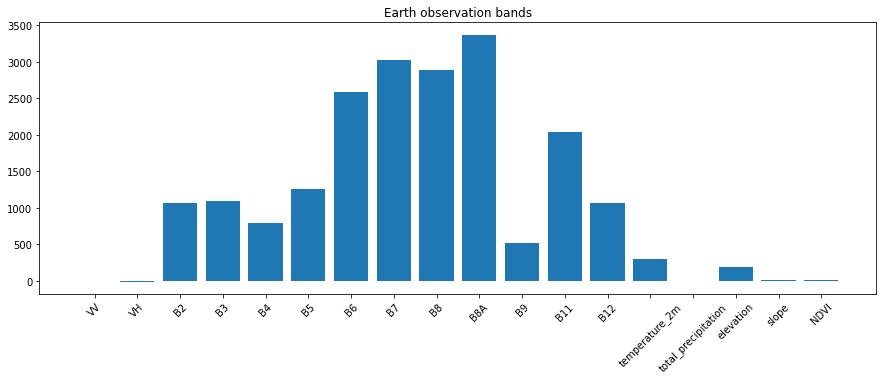

In [15]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.bar(x=BANDS, height=crop_earth_observation_data[10])
ax.set_title("Earth observation bands")
plt.xticks(rotation=45);

### ❗**Challenge**❗

Plot the NDVI (normalized difference vegetation index) for crop and non-crop data over a one year period.

Crop: http://maps.google.com/maps?z=12&t=k&q=loc:7.5845981+1.41240946
Non-crop: http://maps.google.com/maps?z=12&t=k&q=loc:10.87840903+-0.00512438


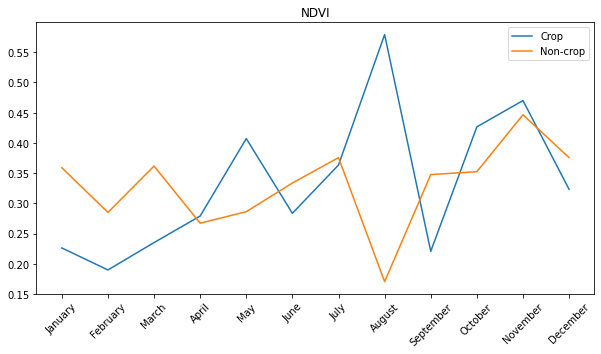

In [17]:
def get_ndvi(feature_path):
  feature_instance = load_feature(feature_path)
  earth_observation_data = feature_instance.labelled_array
  ndvi_for_one_year = earth_observation_data[:12, -1]
  return ndvi_for_one_year

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("NDVI")
plt.xticks(rotation=45)

crop_feature_path = crop_label[FEATURE_PATH]
crop_ndvi = get_ndvi(crop_feature_path)
ax.plot(MONTHS, crop_ndvi, label="Crop")

##########################################
non_crop_label = df[(df[CLASS_PROB] == 0.0) & (df[SUBSET] == "validation")].iloc[0]# YOUR CODE HERE
##########################################
non_crop_feature_path = non_crop_label[FEATURE_PATH]
non_crop_ndvi = get_ndvi(non_crop_feature_path)
ax.plot(MONTHS, non_crop_ndvi, label="Non-crop")

ax.legend()

gmap_url = "http://maps.google.com/maps?z=12&t=k&q=loc:"
print(f"Crop: {gmap_url}{crop_label[LAT]}+{crop_label[LON]}")
print(f"Non-crop: {gmap_url}{non_crop_label[LAT]}+{non_crop_label[LON]}")

## 3. Train cropland model 🏋️‍♂️

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/step2.png" width="80%"/>

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/train_model.png" width="80%" />

In [18]:
!pip install tsai -q

ERROR: thinc 8.0.17 has requirement typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you'll have typing-extensions 4.2.0 which is incompatible.
ERROR: spacy 3.3.1 has requirement typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you'll have typing-extensions 4.2.0 which is incompatible.
ERROR: imbalanced-learn 0.9.1 has requirement scikit-learn>=1.1.0, but you'll have scikit-learn 1.0.2 which is incompatible.
You should consider upgrading via the '/Users/izvonkov/nasaharvest/openmapflow/venv/bin/python -m pip install --upgrade pip' command.


In [19]:
import os
os.environ["MODEL_NAME"] = input("MODEL_NAME=")

MODEL_NAME=test_model


`train.py` can be opened in Colab directly using the sidebar.

In [20]:
!python train.py --model_name $MODEL_NAME --epoch 3

Upsampling: positive class from 7807 to 13727 using upsampling ratio: 0.5
Loading data into memory
Caching files: 100%|████████████████████| 41181/41181 [00:34<00:00, 1206.30it/s]
Loading data into memory
Train: 100%|████████████████████████████████▊| 641/644 [00:04<00:00, 147.96it/s]
                                                                                
Train: 100%|████████████████████████████████▉| 643/644 [00:04<00:00, 145.24it/s]
                                                                                
Validate:   0%|                                           | 0/5 [00:00<?, ?it/s]


Train: 100%|█████████████████████████████████| 644/644 [00:04<00:00, 141.44it/s]
                                                                                
Epoch: 100%|██████████████████████████| 3/3 [00:13<00:00,  4.67s/it, loss=0.676]
MODEL_NAME=test_model
accuracy: 0.6173
f1: 0.6624
precision: 0.6624
recall: 0.6624
roc_auc: 0.6752



### ❗**Optional Challenge**❗

Try to improve the model by modifying `crop-mask-example/train.py` in Colab directly

## 4. Inference over small region 🗺️

In [21]:
from openmapflow.train_utils import model_path_from_name
from openmapflow.config import PROJECT
from cropharvest.inference import Inference
from cropharvest.bands import DYNAMIC_BANDS
from tqdm.notebook import tqdm
from pathlib import Path
from datetime import date
import cmocean
import numpy as np
import rasterio as rio
import torch
import tempfile

In [22]:
tifs_dir = Path(f"{tempfile.tempdir}/tifs")
preds_dir = Path(f"{tempfile.tempdir}/preds")
tifs_dir.mkdir(exist_ok=True)
preds_dir.mkdir(exist_ok=True)

def merge_tifs(full_prefix):
  vrt_in_file = f"{full_prefix}*"
  vrt_out_file = f"{full_prefix}.vrt"
  merged_file = f"{full_prefix}.tif"
  !gdalbuildvrt {vrt_out_file} {vrt_in_file}
  !gdal_translate -a_srs EPSG:4326 -of GTiff {vrt_out_file} {merged_file}
  return merged_file

In [24]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=LWVPP4zXp8wvzOGN9aK36HMiqqBlXb&access_type=offline&code_challenge=8EeVgXD1HN-aiIkbrzqXYjL6H3zg3im_4o2PNSqXIh0&code_challenge_method=S256


You are now logged in as [ivan.zvonkov@gmail.com].
Your current project is [bsos-geog-harvest1].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


### Download example inference data

In [25]:
prefix = "gs://harvest-public-assets/openmapflow/Togo_2019_demo_2019-02-01_2020-02-01"
paths = [
  f"{prefix}/00000000000-0000000000.tif",
  f"{prefix}/00000000000-0000000256.tif",
  f"{prefix}/00000000256-0000000000.tif",
  f"{prefix}/00000000256-0000000256.tif"         
]

for p in tqdm(paths):
  !gsutil -m cp {p} {tifs_dir}/{Path(p).name}

  0%|          | 0/4 [00:00<?, ?it/s]

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://harvest-public-assets/openmapflow/Togo_2019_demo_2019-02-01_2020-02-01/00000000000-0000000000.tif...
/ [1/1 files][ 47.5 MiB/ 47.5 MiB] 100% Done 499.7 KiB/s ETA 00:00:00           
Operation completed over 1 objects/47.5 MiB.                                     
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://harvest-

In [26]:
merged_eo_file = merge_tifs(full_prefix=f"{tifs_dir}/")

zsh:1: command not found: gdalbuildvrt
zsh:1: command not found: gdal_translate


In [ ]:
def normalize(array):
    array_min, array_max = array.min(), array.max()*0.5
    return ((array - array_min)/(array_max - array_min))

month = 2
rgb_indexes = [DYNAMIC_BANDS.index(b) for b in ["B4", "B3", "B2"]]
eo_data = rio.open(merged_eo_file)
colors = [eo_data.read(i + month*len(DYNAMIC_BANDS)) for i in rgb_indexes]
normalized_colors = [normalize(c) for c in colors]
rgb = np.dstack(normalized_colors)
plt.figure(figsize=(10,10))
plt.title("Earth Observation data for one month")
plt.axis('off')
plt.imshow(rgb);

### Make predictions with model

In [ ]:
model = torch.jit.load(model_path_from_name(os.environ["MODEL_NAME"]))
inference = Inference(model=model, normalizing_dict=None)
local_pred_paths = []
tifs = list(Path(tifs_dir).glob("*.tif"))
for local_tif_path in tqdm(tifs, desc="Making predictions"):
  local_pred_path = Path(f"{preds_dir}/pred_{local_tif_path.stem}.nc")
  inference.run(
      local_path=local_tif_path, 
      start_date=date(2019, 2, 1), 
      dest_path=local_pred_path
  )
  local_pred_paths.append(local_pred_path)

### Merge predictions into map

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/merging_predictions.png" width="50%"/>

In [ ]:
merged_pred_file = merge_tifs(full_prefix=f"{preds_dir}/")

### Visualize predictions

In [ ]:
# Visualize
predictions_map = rio.open(merged_pred_file)
if "maize" in PROJECT:
  cmap = cmocean.cm.solar
elif "crop" in PROJECT:
  cmap = cmocean.cm.speed
else:
  cmap = cmocean.cm.thermal

plt.figure(figsize=(10,10))
plt.imshow(predictions_map.read(1).clip(0,1), cmap=cmap)
plt.title(f"Map Preview: {PROJECT}")
plt.colorbar(fraction=0.03, pad=0.04)
plt.axis("off");

## 5. [OPTIONAL] Deployment - Push to dvc and git
This will only work if you have forked the repository or have write access to the source repository.

In [ ]:
# Generate test metrics
!python evaluate.py --model_name $MODEL_NAME

In [ ]:
!dvc commit -q 
!dvc push -q

In [ ]:
!git checkout -b"$MODEL_NAME"
!git add .
!git commit -m "$MODEL_NAME"
!git push --set-upstream origin "$MODEL_NAME"

Once Pull Request is merged model will be deployed for map creation.

<img src="https://storage.googleapis.com/harvest-public-assets/openmapflow/step3.png" width="80%"/>